# Google Drive Preliminaries

In [ ]:
#-- "Mount" Google Drive to access data and save files/images --#
# NOTE: If running locally, comment out this cell and change the basePath accordingly
# Reference: https://stackoverflow.com/questions/49031798/when-i-use-google-colaboratory-how-to-save-image-weights-in-my-google-drive
from google.colab import drive
drive.mount('/content/gdrive')

# You will be asked to sign into a Google account and give GoogleColab access

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# To check that mounting worked, uncomment and run the following. You should see the contents of the directory listed.
! ls '/content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OnML4Jets2021DataChallenge/Data/'

Ato4l_lepFilter_13TeV_filtered.h5
background_for_training.h5
BlackBox_background_mix.h5
hChToTauNu_13TeV_PU20_filtered.h5
hToTauTau_13TeV_PU20_filtered.h5
leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5
OldBuggedDatasets


In [ ]:
sigAliasList    = ['sig_A', 'sig_h0', 'sig_hch', 'sig_LQ']
sigFilenameList = ['Ato4l_lepFilter_13TeV_filtered.h5', 'hToTauTau_13TeV_PU20_filtered.h5', 'hChToTauNu_13TeV_PU20_filtered.h5', 'leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5']

In [ ]:
#-- Set base directory and data directory path --#
basePath   = '/content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OnML4Jets2021DataChallenge/'
dataPath   = 'Data/'

bkgPath    = basePath+dataPath+'background_for_training.h5'
sigPathList = []
for x in sigFilenameList:
  sigPathList.append(basePath+dataPath+x)

# Import libraries

In [ ]:
!pip install POT

In [ ]:
import numpy as np
from numpy.random import RandomState
import numpy.ma as ma

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline

import h5py
import ot
from numpy.random import Generator, PCG64
from sklearn import metrics
import itertools

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier

/usr/local/lib/python3.10/dist-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


# Functions

In [ ]:
%cd /content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OnML4Jets2021DataChallenge/
%run centralFunctions.ipynb

/content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OnML4Jets2021DataChallenge


# Loading Data

In [ ]:
dataDict = {}
dataDict['bkg'] = h5py.File(bkgPath, 'r')

for i in range(len(sigAliasList)):
  alias   = sigAliasList[i]
  sigPath = sigPathList[i]
  dataDict[alias] = h5py.File(sigPath, 'r')

In [ ]:
print("Background Keys in file (f_bkg := dataDict['bkg']):")
for key in dataDict['bkg'].keys():
  print("  ",key)
  print("      f_bkg[%s]"%key)
  print("           .shape: ", dataDict['bkg'][key].shape)
  print("           .dtype: ", dataDict['bkg'][key].dtype)

for alias in sigAliasList:
  print("")
  print("Signal Keys in file (f_sig := dataDict['%s']):"%alias)
  for key in dataDict[alias].keys():
    print("  ",key)
    print("      f_sig[%s]"%key)
    print("           .shape: ", dataDict[alias][key].shape)
    print("           .dtype: ", dataDict[alias][key].dtype)

Background Keys in file (f_bkg := dataDict['bkg']):
   Particles
      f_bkg[Particles]
           .shape:  (13451915, 19, 4)
           .dtype:  float64
   Particles_Classes
      f_bkg[Particles_Classes]
           .shape:  (4,)
           .dtype:  |S16
   Particles_Names
      f_bkg[Particles_Names]
           .shape:  (4,)
           .dtype:  |S5

Signal Keys in file (f_sig := dataDict['sig_A']):
   Particles
      f_sig[Particles]
           .shape:  (55969, 19, 4)
           .dtype:  float64
   Particles_Classes
      f_sig[Particles_Classes]
           .shape:  (4,)
           .dtype:  |S16
   Particles_Names
      f_sig[Particles_Names]
           .shape:  (4,)
           .dtype:  |S5

Signal Keys in file (f_sig := dataDict['sig_h0']):
   Particles
      f_sig[Particles]
           .shape:  (691283, 19, 4)
           .dtype:  float64
   Particles_Classes
      f_sig[Particles_Classes]
           .shape:  (388,)
           .dtype:  |S16
   Particles_Names
      f_sig[Particles_N

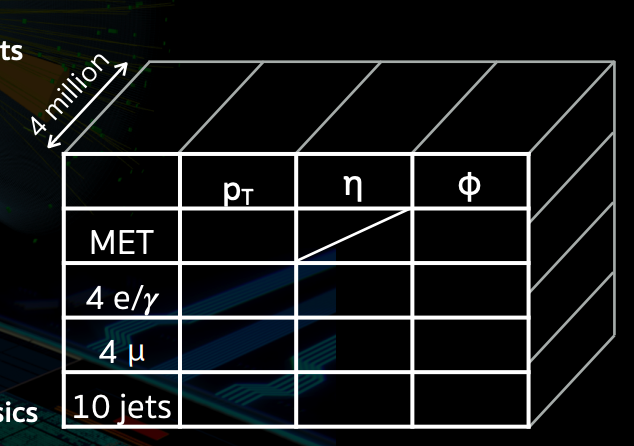

# 3D OT distances with the naive implementation

In [ ]:
bkg_data = dataDict['bkg']['Particles'][:, :, 0:3]
sig_data = {}

for alias in sigAliasList:
  sig_data[alias] = dataDict[alias]['Particles'][:, :, 0:3]

In [ ]:
nEvents   = 100

dataSamplesDict = {}

# Generate 2 different samples of nEvents Background events
random_state            = Generator(PCG64(123))
dataSamplesDict['bkgEvents1'] = randomDataSample(bkg_data, nEvents, random_state)

random_state            = Generator(PCG64(456))
dataSamplesDict['bkgEvents2'] = randomDataSample(bkg_data, nEvents, random_state)

# For each signal type, generate a sample of nEvents Signal events
for alias in sigAliasList:
  random_state          = Generator(PCG64(123))
  dataSamplesDict[alias]      = randomDataSample(sig_data[alias], nEvents, random_state)

In [ ]:
OTSCHEME = {}
OTSCHEME['normPT'] = False
OTSCHEME['balanced'] = True
OTSCHEME['noZeroPad'] = False
OTSCHEME['individualOT'] = False

scoreDict = {}

scoreDict['CBB'], scoreDict['wBB'] = calcOTDistance(dataSamplesDict['bkgEvents1'],dataSamplesDict['bkgEvents2'], OTSCHEME, COSTSCHEME='3D')

for alias in sigAliasList:
  scoreDict['CBS_'+alias],scoreDict['wBS_'+alias] = calcOTDistance(dataSamplesDict['bkgEvents1'], dataSamplesDict[alias], OTSCHEME, COSTSCHEME='3D')

bkg_scores = scoreDict['wBB']
sig_scores = []
sig_scores_list = []
for alias in sigAliasList:
  sig_scores_list.append(scoreDict['wBS_'+alias])
  sig_scores.extend(scoreDict['wBS_'+alias])

In [ ]:
print(scoreDict['wBB'].shape)

(5050,)


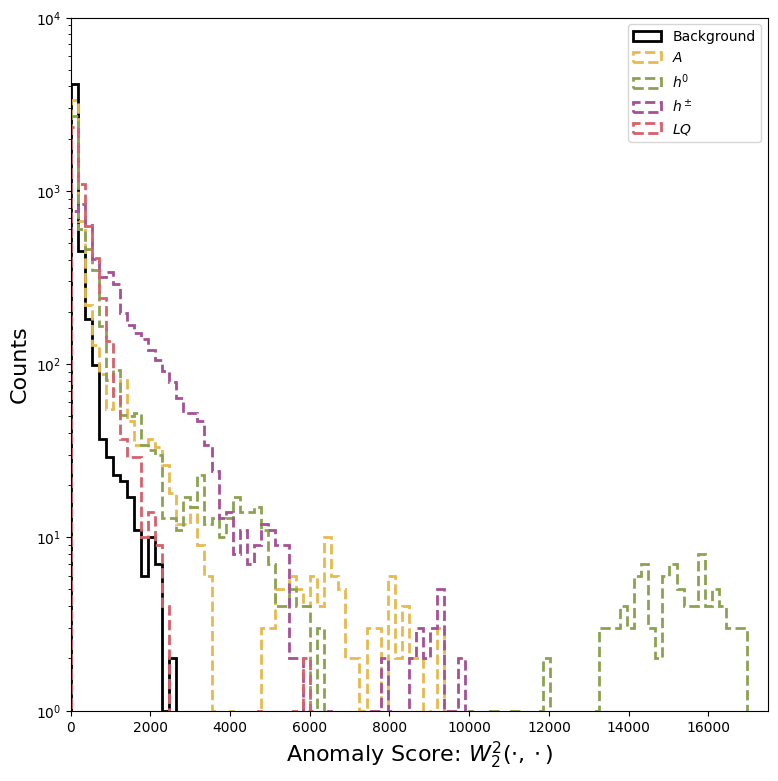

In [ ]:
# Define colors to use for 4 signal types
SIGNAL_COLOR_ARR = np.array([ RGBAtoRGBAtuple((231, 186, 81, 1), TYPE='list'),
                              RGBAtoRGBAtuple((140, 162, 82, 1), TYPE='list'),
                              RGBAtoRGBAtuple((165, 81, 148, 1), TYPE='list'),
                              RGBAtoRGBAtuple((214, 97, 107, 1), TYPE='list')
                              ])

plotArgDict = {}
plotArgDict['pltDim']             = (3,3)
plotArgDict['xAxisLims']          = (0, 17500)
plotArgDict['xLabel']             = r'Anomaly Score: $W_2^2(\cdot, \cdot)$'
plotArgDict['yAxisLims']          = (1, 1e4)
plotArgDict['yLabel']             = r'Counts'
plotArgDict['title']              = r''
plotArgDict['nBins']              = 100
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotScoreHists(bkg_scores, sig_scores_list, plotArgDict)

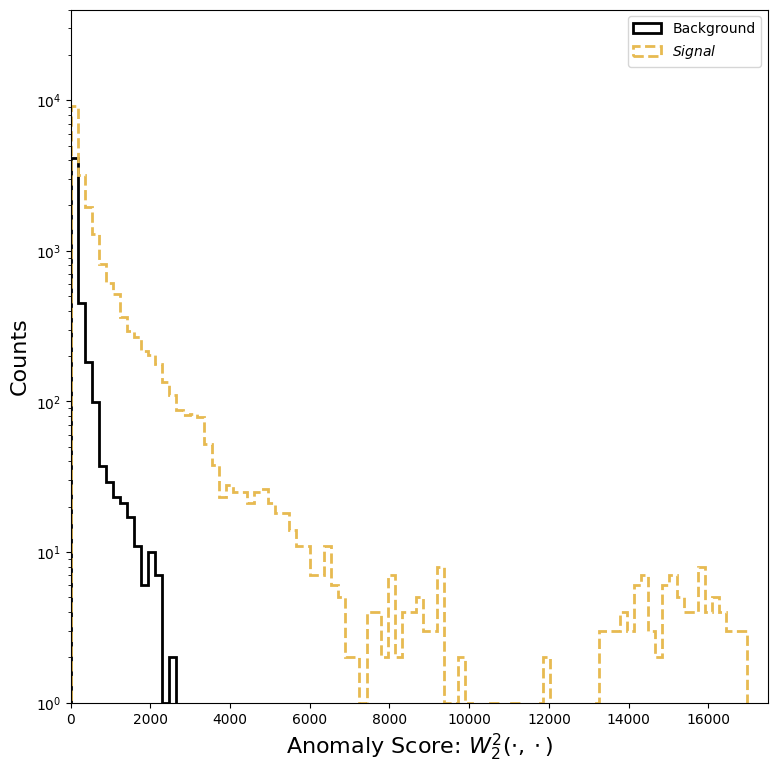

In [ ]:
SIGNAL_COLOR_ARR = np.array([RGBAtoRGBAtuple((231, 186, 81, 1), TYPE='list')])

plotArgDict = {}
plotArgDict['pltDim']             = (3,3)
plotArgDict['xAxisLims']          = (0, 17500)
plotArgDict['xLabel']             = r'Anomaly Score: $W_2^2(\cdot, \cdot)$'
plotArgDict['yAxisLims']          = (1, 4e4)
plotArgDict['yLabel']             = r'Counts'
plotArgDict['title']              = r''
plotArgDict['nBins']              = 100
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$Signal$']

plotScoreHists(bkg_scores, [sig_scores], plotArgDict)

# kNN Classification

In [ ]:
# np.random.seed(123)
# np.random.shuffle(bkg_scores)
# np.random.shuffle(sig_scores)

# bkg_indicator = np.zeros(len(bkg_scores))
# sig_indicator = np.ones(len(sig_scores))

# x_train = np.concatenate((bkg_scores[:3000],sig_scores[:12000]))
# x_train = x_train.reshape(-1,1)
# y_train = np.concatenate((bkg_indicator[:3000],sig_indicator[:12000]))

# x_val = np.concatenate((bkg_scores[3000:4000],sig_scores[12000:16000]))
# x_val = x_val.reshape(-1,1)
# y_val = np.concatenate((bkg_indicator[3000:4000],sig_indicator[12000:16000]))

# x_trainval = np.concatenate((bkg_scores[:4000],sig_scores[:16000]))
# x_trainval = x_trainval.reshape(-1,1)
# y_trainval = np.concatenate((bkg_indicator[:4000],sig_indicator[:16000]))

# x_test = np.concatenate((bkg_scores[4000:],sig_scores[16000:]))
# x_test = x_test.reshape(-1,1)
# y_test = np.concatenate((bkg_indicator[4000:],sig_indicator[16000:]))

# print(len(bkg_scores),len(sig_scores))
# print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_trainval.shape, y_trainval.shape, x_test.shape, y_test.shape)

In [ ]:
# neighbor_list = list(range(10,500,10))
# models, pred_vals = [], []
# for neighbor in neighbor_list:
#   print("Processing neighbor k=", neighbor)
#   model = KNeighborsClassifier(n_neighbors=neighbor)
#   model.fit(x_train,y_train)
#   pred_val = model.predict_proba(x_val)[:,1]
#   models.append(model)
#   pred_vals.append(pred_val)

In [ ]:
# auc_list = []
# for pred in pred_vals:
#     auc = roc_auc_score(y_val, pred)
#     auc_list.append(auc)

# max_index = auc_list.index(max(auc_list))
# best_k = neighbor_list[max_index]
# print(max(auc_list))
# print(best_k)
# print(auc_list)

In [ ]:
# best_model = KNeighborsClassifier(n_neighbors=best_k)
# best_model.fit(x_trainval, y_trainval)
# best_pred = best_model.predict_proba(x_test)[:,1]
# best_auc = roc_auc_score(y_test, best_pred)

In [ ]:
# print(best_auc)

In [ ]:
auc, k = kNN_Classification_Best_Hyperparameters(bkg_scores, sig_scores, 3000, 1000, 1050, 4, list(range(10,500,10)))
print("Best AUC is:", auc)
print("Best number of neighbors is:", k)

Best AUC is: 0.7511379818594105
Best number of neighbors is: 390


In [ ]:
A_score = sig_scores_list[0]
A_auc, A_k = kNN_Classification_Best_Hyperparameters(bkg_scores, A_score, 3000, 1000, 1050, 1, list(range(10,500,10)))
print("Best AUC for A is:", A_auc)
print("Best number of neighbors for A is:", A_k)

Best AUC for A is: 0.63402358276644
Best number of neighbors for A is: 490


In [ ]:
h0_score = sig_scores_list[1]
h0_auc, h0_k = kNN_Classification_Best_Hyperparameters(bkg_scores, h0_score, 3000, 1000, 1050, 1, list(range(10,500,10)))
print("Best AUC for h0 is:", h0_auc)
print("Best number of neighbors for A is:", h0_k)

Best AUC for h0 is: 0.6772979591836734
Best number of neighbors for A is: 310


In [ ]:
hpm_score = sig_scores_list[2]
hpm_auc, hpm_k = kNN_Classification_Best_Hyperparameters(bkg_scores, hpm_score, 3000, 1000, 1050, 1, list(range(10,500,10)))
print("Best AUC for hpm is:", hpm_auc)
print("Best number of neighbors for A is:", hpm_k)

Best AUC for hpm is: 0.9045242630385488
Best number of neighbors for A is: 440


In [ ]:
LQ_score = sig_scores_list[3]
LQ_auc, LQ_k = kNN_Classification_Best_Hyperparameters(bkg_scores, LQ_score, 3000, 1000, 1050, 1, list(range(10,500,10)))
print("Best AUC for LQ is:", LQ_auc)
print("Best number of neighbors for A is:", LQ_k)

Best AUC for LQ is: 0.7608893424036279
Best number of neighbors for A is: 160
